## DeZeroで「ゼロから作るDeep Learning 8章 ディープラーニング」を参考に少し深いCNN実装
 - [ゼロから作るDeep Learning](https://www.oreilly.co.jp/books/9784873117584/)の「8章 ディープラーニング」のCNNを参考に次のCNNを実装してみる。
   - 最適化手法：Adam
   - 20エポック後の畳み込み層の画像を[oreilly-japan/deep-learning-from-scratch/ch07/visualize_filter.py](https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/ch07/visualize_filter.py)の`filter_show`関数を利用させて頂き表示。
```
Conv(16, 3)->ReLU->C(16, 3)->R->Pool->C(32, 3)->R->C(32, 3)->R->P->Affine->R->Dropout->A->D->Softmax
Conv(チャンネル数, フィルターサイズ)
```

 - [qitqito/dezero_study/mnist_conv.py](https://github.com/qitqito/dezero_study/blob/master/mnist_conv.py)に実装があります。以下に貼り付けました。ローカルで実行するにはDeZeroをインストール（`pip install dezero`）して下さい。

epoch: 1
train loss: 0.7745880496005217, accuracy: 0.8107166666666666
test loss: 0.21437150230631233, accuracy: 0.9265
epoch: 2
train loss: 0.18387772805367908, accuracy: 0.9435666666666667
test loss: 0.12934451738372446, accuracy: 0.9572
epoch: 3
train loss: 0.12505377058405429, accuracy: 0.9619666666666666
test loss: 0.10398872148245573, accuracy: 0.9714
epoch: 4
train loss: 0.10075697976940622, accuracy: 0.9701166666666666
test loss: 0.09195344189414754, accuracy: 0.9736
epoch: 5
train loss: 0.08086445924282695, accuracy: 0.9756666666666667
test loss: 0.08986783667933196, accuracy: 0.9747
epoch: 6
train loss: 0.06618870926244805, accuracy: 0.9802666666666666
test loss: 0.07596710937796161, accuracy: 0.9782
epoch: 7
train loss: 0.062247648977208886, accuracy: 0.9816166666666667
test loss: 0.0732591821620008, accuracy: 0.9806
epoch: 8
train loss: 0.058036071138922125, accuracy: 0.9833833333333334
test loss: 0.0619221124087926, accuracy: 0.9816
epoch: 9
train loss: 0.0479881908626218, 

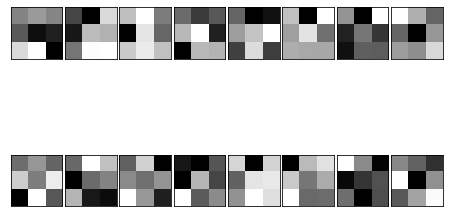

conv1_2


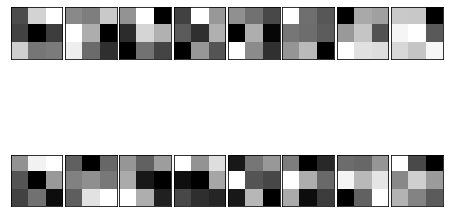

conv2_1


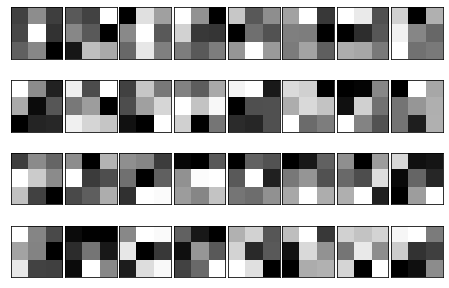

conv2_2


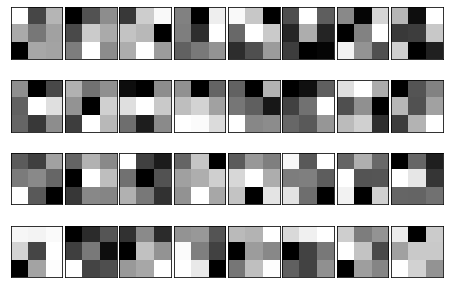

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import dezero
import dezero.functions as F
from dezero import DataLoader
from dezero.models import Model
import dezero.layers as L


def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

class MNISTConv(Model):
    def __init__(self, hidden_size=100):
        super().__init__()
        self.conv1_1 = L.Conv2d(16, kernel_size=3, stride=1, pad=1)
        self.conv1_2 = L.Conv2d(16, kernel_size=3, stride=1, pad=1)
        self.conv2_1 = L.Conv2d(32, kernel_size=3, stride=1, pad=1)
        self.conv2_2 = L.Conv2d(32, kernel_size=3, stride=1, pad=1)
        self.fc3 = L.Linear(hidden_size)
        self.fc4 = L.Linear(10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x)) # (OH, OW)=(28, 28)
        x = F.relu(self.conv1_2(x)) # (OH, OW)=(28, 28)
        x = F.pooling(x, 2, 2) # (OH, OW)=(14, 14)
        x = F.relu(self.conv2_1(x)) # (OH, OW)=(14, 14)
        x = F.relu(self.conv2_2(x)) # (OH, OW)=(14, 14)
        x = F.pooling(x, 2, 2) # (OH, OW)=(7, 7)
        x = F.reshape(x, (x.shape[0], -1)) # (7, 7)->(49, )
        x = F.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

max_epoch = 20
batch_size = 100

train_set = dezero.datasets.MNIST(train=True, transform=None) # (28, 28)
test_set = dezero.datasets.MNIST(train=False, transform=None) # (28, 28)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MNISTConv()
optimizer = dezero.optimizers.Adam().setup(model)
optimizer.add_hook(dezero.optimizers.WeightDecay(1e-4))  # Weight decay

if dezero.cuda.gpu_enable:
    train_loader.to_gpu()
    test_loader.to_gpu()
    model.to_gpu()

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {}, accuracy: {}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {}, accuracy: {}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

print("conv1_1")
filter_show(model.conv1_1.W.data)
print("conv1_2")
filter_show(model.conv1_2.W.data)
print("conv2_1")
filter_show(model.conv2_1.W.data)
print("conv2_2")
filter_show(model.conv2_2.W.data)

### 考察
 - エポック1から既にMNISTの全結合版よりも良い精度が出ています。適切なニューラルネットワークとはそう言うものなのかも知れません。最終的には99%近くの精度が出ました。8章のCNNと同等ですね。
   - 参照：[qitqito/blog/MNISTPlus.ipynb](https://github.com/qitqito/blog/blob/master/MNISTPlus.ipynb)
 - 畳み込み層を可視化してみましたがサイズが小さいと良くわからないです。